In [4]:
!pip install kaggle

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import os
os.makedirs('~/.kaggle', exist_ok=True)
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
!kaggle datasets download -d manuelbenedicto/figure-eight-labelled-textual-dataset

Dataset URL: https://www.kaggle.com/datasets/manuelbenedicto/figure-eight-labelled-textual-dataset
License(s): unknown
figure-eight-labelled-textual-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile

with zipfile.ZipFile("figure-eight-labelled-textual-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("figure-eight-labelled-textual-dataset")

In [10]:
import pandas as pd

# Load the CSV file
data = pd.read_csv("figure-eight-labelled-textual-dataset/text_emotion.csv")

# Display the first few rows
print(data.head())

     tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...  


In [11]:
!pip install tweet-preprocessor 2>/dev/null 1>/dev/null

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
import preprocessor as p
import numpy as np 
import pandas as pd 
import emoji
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Activation, Dropout, Embedding
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical  # For one-hot encoding
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

In [13]:
!kaggle datasets download -d bittlingmayer/spelling

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/spelling
License(s): unknown
  0%|                                               | 0.00/2.46M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 2.46M/2.46M [00:00<00:00, 139MB/s]


In [14]:
import zipfile

with zipfile.ZipFile("/kaggle/working/spelling.zip", "r") as zip_ref:
    zip_ref.extractall("spelling")

In [15]:
misspell_data = pd.read_csv("/kaggle/working/spelling/aspell.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Sample of the dict
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(20)]}

{'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'Steffen': 'Stephen',
 'susan': 'Susan',
 'abilitey': 'ability',
 'abouy': 'about',
 'absorbtion': 'absorption',
 'accidently': 'accidentally',
 'accomodate': 'accommodate',
 'acommadate': 'accommodate',
 'acord': 'accord',
 'aquantance': 'acquaintance',
 'equire': 'acquire',
 'adultry': 'adultery',
 'aggresive': 'aggressive',
 'alchohol': 'alcohol',
 'alchoholic': 'alcoholic',
 'allieve': 'alive',
 'alright': 'all_right'}

In [16]:
def misspelled_correction(val):
    for x in val.split(): 
        if x in miss_corr.keys(): 
            val = val.replace(x, miss_corr[x]) 
    return val

data["clean_content"] = data.content.apply(lambda x : misspelled_correction(x))

In [17]:
!kaggle datasets download -d ishivinal/contractions

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/ishivinal/contractions
License(s): CC0-1.0
  0%|                                               | 0.00/1.05k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 3.33MB/s]


In [18]:
with zipfile.ZipFile("/kaggle/working/contractions.zip", "r") as zip_ref:
    zip_ref.extractall("contractions")

In [19]:
contractions = pd.read_csv("/kaggle/working/contractions/contractions.csv")
cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))

In [20]:
def cont_to_meaning(val): 
  
    for x in val.split(): 
        if x in cont_dic.keys(): 
            val = val.replace(x, cont_dic[x]) 
    return val

In [16]:
data.clean_content = data.clean_content.apply(lambda x : cont_to_meaning(x))

In [21]:
p.set_options(p.OPT.MENTION, p.OPT.URL)
p.clean("hello guys @alx #sport🔥 1245 https://github.com/s/preprocessor")

'hello guys #sport🔥 1245'

In [22]:
data["clean_content"]=data.content.apply(lambda x : p.clean(x))

In [23]:
def punctuation(val): 
  
    punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
  
    for x in val.lower(): 
        if x in punctuations: 
            val = val.replace(x, " ") 
    return val

In [24]:
punctuation("test @ shivang @ karun ")

'test   shivang   karun '

In [25]:
data.clean_content = data.clean_content.apply(lambda x : ' '.join(punctuation(emoji.demojize(x)).split()))

In [26]:
def clean_text(val):
    val = misspelled_correction(val)
    val = cont_to_meaning(val)
    val = p.clean(val)
    val = ' '.join(punctuation(emoji.demojize(val)).split())
    
    return val

In [27]:
clean_text("i have an idea 💡  ")

'i have an idea light bulb'

In [28]:
data = data[data.clean_content != ""]

In [29]:
data.sentiment.value_counts()

sentiment
neutral       8579
worry         8454
happiness     5208
sadness       5162
love          3841
surprise      2187
fun           1776
relief        1526
hate          1323
empty          815
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [30]:
sent_to_id  = {"empty":0, "sadness":1,"enthusiasm":2,"neutral":3,"worry":4,
                        "surprise":5,"love":6,"fun":7,"hate":8,"happiness":9,"boredom":10,"relief":11,"anger":12}

In [31]:
data["sentiment_id"] = data['sentiment'].map(sent_to_id)

In [32]:
data

,tweet_id,sentiment,author,content,clean_content,sentiment_id
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,i know i was listenin to bad habit earlier and...,0
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh waitin on y...,1
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony gloomy friday,1
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,We want to trade with someone who has Houston ...,3
...,...,...,...,...,...,...
39994,1753918900,happiness,courtside101,Succesfully following Tayla!!,Succesfully following Tayla!!,9
39996,1753919001,love,drapeaux,Happy Mothers Day All my love,Happy Mothers Day All my love,6
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...,Happy Mother s Day to all the mommies out ther...,6
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY NE...,9


In [33]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data.sentiment_id)

# Initialize OneHotEncoder with the updated parameter
onehot_encoder = OneHotEncoder(sparse_output=False)  # Updated parameter name
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# Fit and transform the integer encoded values
Y = onehot_encoder.fit_transform(integer_encoded)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.clean_content,Y, random_state=1995, test_size=0.2, shuffle=True)

In [35]:
print(X_train.head())

33334                      yay mothers day i love mi madre
36141                yay! welcome to the etsy seller world
39424    Having a Y weekend with Karen Off to Swansea t...
36163                                        Is the pantry
25087    ok thanks for the help! I hope they respond to...
Name: clean_content, dtype: object


In [32]:
# embed_dim = 160
# lstm_out = 250

# model = Sequential()
# model.add(Embedding(len(w_idx) + 1, embed_dim, input_length=X_test_pad.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(13, activation='softmax'))  # Use Dense directly from keras.layers
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(model.summary())

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import matplotlib.pyplot as plt

# Tokenizer and padding
token = Tokenizer(num_words=None)
max_len = 160
token.fit_on_texts(list(X_train) + list(X_test))  # Fit tokenizer on both train and test data
X_train_pad = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_len)
X_test_pad = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_len)

w_idx = token.word_index

# Model parameters
embed_dim = 200
lstm_out = 250
epochs = 10  # Number of epochs

# Check data shapes
print("X_test_pad shape:", X_test_pad.shape)
print("Vocabulary size (w_idx):", len(w_idx))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Build the model with a simple LSTM layer
model = Sequential()
model.add(Embedding(input_dim=len(w_idx) + 1, output_dim=embed_dim, input_length=X_test_pad.shape[1]))
model.add(SpatialDropout1D(0.3))  # Reduced dropout to 0.3
model.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.3))  # LSTM with dropout
model.add(Dense(13, activation='softmax'))  # 13 classes for multi-class classification

# Compile the model with a smaller learning rate
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_pad, y_train, 
    epochs=epochs, 
    batch_size=64, 
    validation_data=(X_test_pad, y_test), 
    callbacks=[early_stopping, lr_scheduler]
)




X_test_pad shape: (7984, 160)
Vocabulary size (w_idx): 30219
Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 112s  222ms/step - accuracy: 0.2469 - loss: 2.2587 - val_accuracy: 0.2930 - val_loss: 2.1267 - learning_rate: 1.0000e-04
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s  221ms/step - accuracy: 0.2822 - loss: 2.1248 - val_accuracy: 0.3074 - val_loss: 2.0959 - learning_rate: 1.0000e-04
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s  220ms/step - accuracy: 0.3090 - loss: 2.0711 - val_accuracy: 0.3555 - val_loss: 1.9992 - learning_rate: 1.0000e-04
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s  221ms/step - accuracy: 0.3515 - loss: 1.9946 - val_accuracy: 0.3723 - val_loss: 1.9578 - learning_rate: 1.0000e-04
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 112s  225ms/step - accuracy: 0.3834 - loss: 1.9046 - val_accuracy: 0.3883 - val_loss: 1.9295 - learning_rate: 1.0000e-04
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 111s  223ms/step - accuracy: 0.4068 - loss: 1.8542 - val_accuracy: 0.3978 - val_loss: 1.9189 -

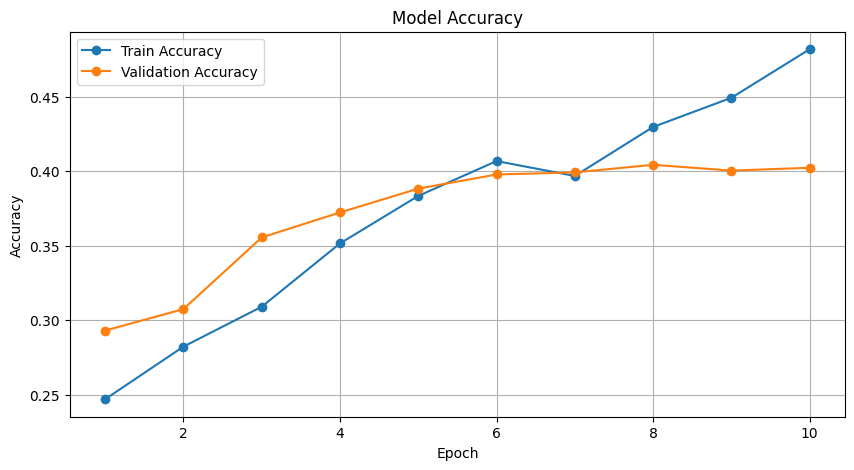

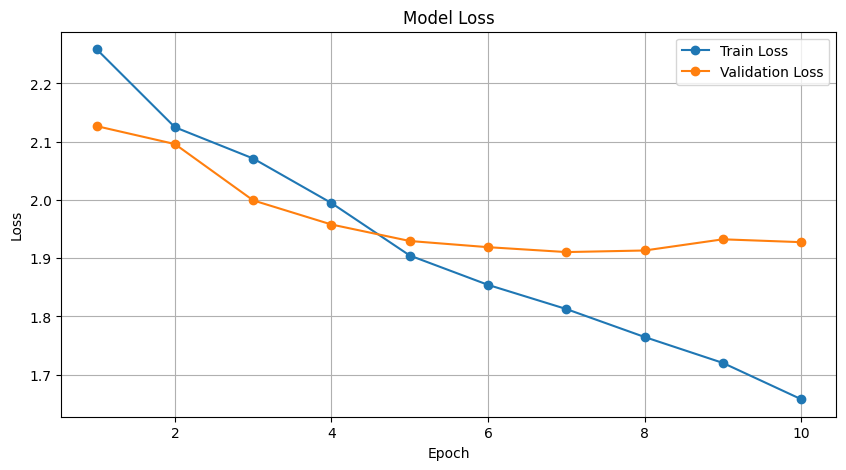

In [1]:
# Visualizing the training process
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
def get_sentiment(model,text):
    text = clean_text(text)
    #tokenize
    twt = token.texts_to_sequences([text])
    twt = sequence.pad_sequences(twt, maxlen=max_len, dtype='int32')
    sentiment = model.predict(twt,batch_size=1,verbose = 2)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([sent_to_id.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result

In [36]:
def plot_result(df):
    #colors=['#D50000','#000000','#008EF8','#F5B27B','#EDECEC','#D84A09','#019BBD','#FFD000','#7800A0','#098F45','#807C7C','#85DDE9','#F55E10']
    #fig = go.Figure(data=[go.Pie(labels=df.sentiment,values=df.percentage, hole=.3,textinfo='percent',hoverinfo='percent+label',marker=dict(colors=colors, line=dict(color='#000000', width=2)))])
    #fig.show()
    colors={'love':'rgb(213,0,0)','empty':'rgb(0,0,0)',
                    'sadness':'rgb(0,142,248)','enthusiasm':'rgb(245,178,123)',
                    'neutral':'rgb(237,236,236)','worry':'rgb(216,74,9)',
                    'surprise':'rgb(1,155,189)','fun':'rgb(255,208,0)',
                    'hate':'rgb(120,0,160)','happiness':'rgb(9,143,69)',
                    'boredom':'rgb(128,124,124)','relief':'rgb(133,221,233)',
                    'anger':'rgb(245,94,16)'}
    col_2={}
    for i in result.sentiment.to_list():
        col_2[i]=colors[i]
    fig = px.pie(df, values='percentage', names='sentiment',color='sentiment',color_discrete_map=col_2,hole=0.3)
    fig.show()

In [37]:
result =get_sentiment(model,"I am so happy today!")
plot_result(result)

1/1 - 0s - 248ms/step


In [38]:
result =get_sentiment(model,"The pain my heart feels is just too much for it to bear. Nothing eases this pain. I can’t hold myself back. I really miss you")
plot_result(result)

1/1 - 0s - 73ms/step


In [39]:
result =get_sentiment(model,"I hate this game so much,It make me angry all the time ")
plot_result(result)

1/1 - 0s - 75ms/step


In [40]:
batch_size = 32

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2 
import tensorflow as tf
import matplotlib.pyplot as plt

# Tokenizer and padding
token = Tokenizer(num_words=None)
max_len = 160
token.fit_on_texts(list(X_train) + list(X_test))  # Fit tokenizer on both train and test data
X_train_pad = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_len)
X_test_pad = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_len)

w_idx = token.word_index

# Model parameters
embed_dim = 200
lstm_out = 250
epochs = 10  # Increased epochs for better training

# Check data shapes
print("X_test_pad shape:", X_test_pad.shape)
print("Vocabulary size (w_idx):", len(w_idx))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Build the model
# Adjust Dropout and Learning Rate
model = Sequential()
model.add(Embedding(input_dim=len(w_idx) + 1, output_dim=embed_dim, input_length=X_test_pad.shape[1]))
model.add(SpatialDropout1D(0.3))  # Reduced dropout to 0.3
model.add(Bidirectional(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))  # Reduced dropout and regularization
model.add(BatchNormalization())
model.add(Dense(13, activation='softmax'))  # 13 classes for multi-class classification

# Compile the model with a smaller learning rate
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Train the model again with more epochs
history = model.fit(
    X_train_pad, y_train, 
    epochs=10,  # Increased epochs
    batch_size=64, 
    validation_data=(X_test_pad, y_test), 
    callbacks=[early_stopping, lr_scheduler]
)




X_test_pad shape: (7984, 160)
Vocabulary size (w_idx): 30219
Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━ 193s  379ms/step - accuracy: 0.2218 - loss: 3.0624 - val_accuracy: 0.3571 - val_loss: 2.4526 - learning_rate: 1.0000e-04
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━ 189s  380ms/step - accuracy: 0.3719 - loss: 2.3101 - val_accuracy: 0.4084 - val_loss: 2.1245 - learning_rate: 1.0000e-04
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━ 188s  376ms/step - accuracy: 0.4261 - loss: 2.0571 - val_accuracy: 0.4161 - val_loss: 2.0630 - learning_rate: 1.0000e-04
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━ 191s  383ms/step - accuracy: 0.4659 - loss: 1.9326 - val_accuracy: 0.4569 - val_loss: 2.0556 - learning_rate: 1.0000e-04
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━ 188s  377ms/step - accuracy: 0.4928 - loss: 1.8409 - val_accuracy: 0.4646 - val_loss: 2.0429 - learning_rate: 1.0000e-04
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━ 186s  373ms/step - accuracy: 0.5186 - loss: 1.7298 - val_accuracy: 0.4573 - val_loss: 2.0449 - learn

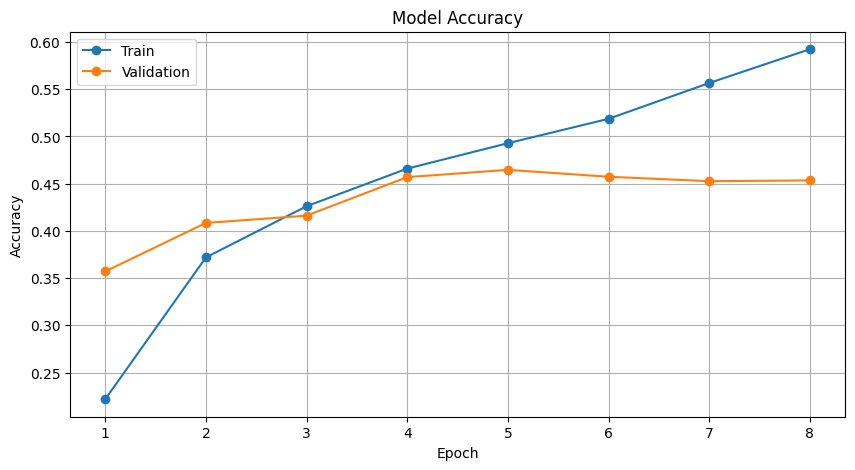

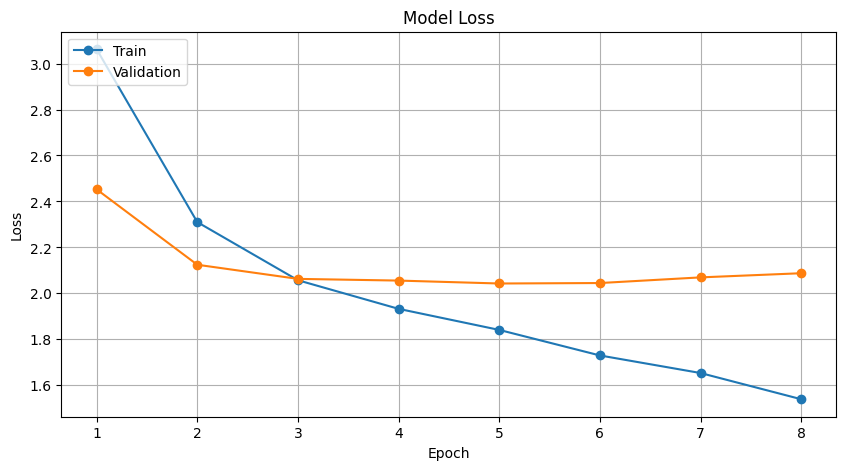

In [2]:
# Visualizing the training process
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
result =get_sentiment(model,"I am so happy today!")
plot_result(result)


1/1 - 0s - 359ms/step


In [46]:
result =get_sentiment(model,"The pain my heart feels is just too much for it to bear. Nothing eases this pain. I can’t hold myself back. I really miss you")
plot_result(result)


1/1 - 0s - 76ms/step


In [47]:
result =get_sentiment(model,"I hate this game so much,It make me angry all the time ")
plot_result(result)

1/1 - 0s - 77ms/step


In [48]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Bidirectional

# Assuming X_test_pad and w_idx are defined
embed_dim = 200
lstm_out = 250

# Check that X_test_pad and w_idx are defined
print("X_test_pad shape:", X_test_pad.shape)
print("Vocabulary size (w_idx):", len(w_idx))

# Build the model
model = Sequential()

# Add the embedding layer
model.add(Embedding(input_dim=len(w_idx) + 1, output_dim=embed_dim, input_length=X_test_pad.shape[1]))

# Add spatial dropout for regularization
model.add(SpatialDropout1D(0.2))

# Add the first Bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))

# Add the second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_out // 2, dropout=0.2, recurrent_dropout=0.2)))

# Add Dense layer with ReLU activation
model.add(Dense(128, activation='relu'))

# Add the Dense output layer for classification
model.add(Dense(13, activation='softmax'))

# Explicitly build the model
model.build((None, X_test_pad.shape[1]))  # Specify the input shape

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())


X_test_pad shape: (7984, 160)
Vocabulary size (w_idx): 30219


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 160, 200)       │     6,044,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 160, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 160, 500)       │       902,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 250)            │       626,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,605,805 (29.01 MB)

 Trainable params: 7,605,805 (29.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [98]:
model.fit(X_train_pad, y_train, epochs = 8, batch_size=128,validation_data=(X_test_pad, y_test))

Epoch 1/8
499/499 ━━━━━━━━━━━━━━━━━━━ 193s  379ms/step - accuracy: 0.2318 - loss: 3.0624 - val_accuracy: 0.3671 - val_loss: 2.4526 - learning_rate: 1.0000e-04
Epoch 2/8
499/499 ━━━━━━━━━━━━━━━━━━━ 189s  380ms/step - accuracy: 0.3819 - loss: 2.3101 - val_accuracy: 0.4184 - val_loss: 2.1245 - learning_rate: 1.0000e-04
Epoch 3/8
499/499 ━━━━━━━━━━━━━━━━━━━ 188s  376ms/step - accuracy: 0.4361 - loss: 2.0571 - val_accuracy: 0.4261 - val_loss: 2.0630 - learning_rate: 1.0000e-04
Epoch 4/8
499/499 ━━━━━━━━━━━━━━━━━━━ 191s  383ms/step - accuracy: 0.4759 - loss: 1.9326 - val_accuracy: 0.4669 - val_loss: 2.0556 - learning_rate: 1.0000e-04
Epoch 5/8
499/499 ━━━━━━━━━━━━━━━━━━━ 188s  377ms/step - accuracy: 0.5028 - loss: 1.8409 - val_accuracy: 0.4746 - val_loss: 2.0429 - learning_rate: 1.0000e-04
Epoch 6/8
499/499 ━━━━━━━━━━━━━━━━━━━ 186s  373ms/step - accuracy: 0.5286 - loss: 1.7298 - val_accuracy: 0.4673 - val_loss: 2.0449 - learning_rate: 1.0000e-04
Epoch 7/8
499/499 ━━━━━━━━━━━━━━━━━━━ 191s  38

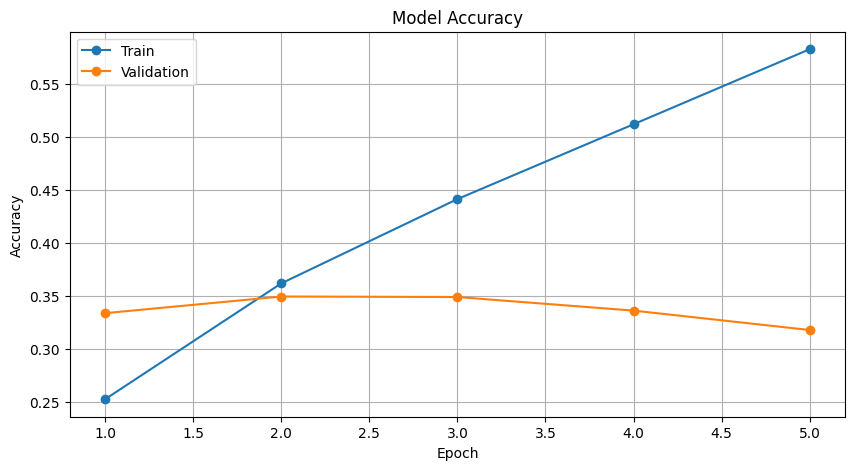

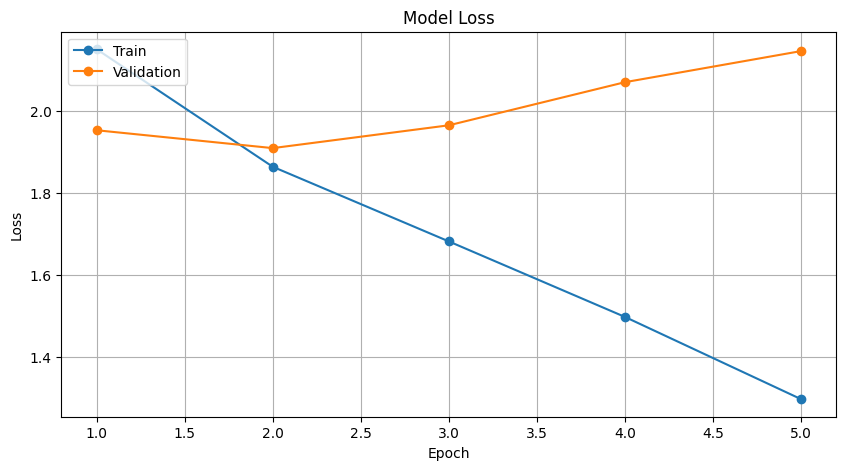

In [3]:
# Visualizing the training process
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [51]:
result =get_sentiment(model,"I am so happy today!")
plot_result(result)


1/1 - 1s - 690ms/step


In [52]:
result =get_sentiment(model,"The pain my heart feels is just too much for it to bear. Nothing eases this pain. I can’t hold myself back. I really miss you")
plot_result(result)

1/1 - 0s - 155ms/step


In [53]:
result =get_sentiment(model,"I hate this game so much,It make me angry all the time ")
plot_result(result)

1/1 - 0s - 156ms/step


In [54]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
glove-global-vectors-for-word-representation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
import zipfile

with zipfile.ZipFile("glove-global-vectors-for-word-representation.zip", "r") as zip_ref:
    zip_ref.extractall("glove-global-vectors-for-word-representation")

In [56]:
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() 
        word2vector = {}
        for line in f:
            line_ = line.strip() 
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [57]:
vocab, word_to_idx =read_data("/kaggle/working/glove-global-vectors-for-word-representation/glove.6B.200d.txt")

Total Words in DataSet: 400000


In [58]:
embedding_matrix = np.zeros((len(w_idx) + 1, 200))
for word, i in w_idx.items():
    embedding_vector = word_to_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

# Define embedding dimension and LSTM units
embed_dim = 200
lstm_out = 250

# Build the model
model_lstm_gwe = Sequential()
model_lstm_gwe.add(Embedding(input_dim=len(w_idx) + 1,  # Vocabulary size (+1 for padding index)
                             output_dim=embed_dim,      # Embedding dimensions
                             input_length=X_test_pad.shape[1],  # Input sequence length
                             weights=[embedding_matrix],  # Pre-trained embeddings
                             trainable=False))           # Set to False to freeze embeddings
model_lstm_gwe.add(SpatialDropout1D(0.2))                # Dropout in embeddings
model_lstm_gwe.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model_lstm_gwe.add(Dense(13, activation='softmax'))      # Output layer with 13 categories

# Compile the model
model_lstm_gwe.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model_lstm_gwe.summary())


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     6,044,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,044,000 (23.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,044,000 (23.06 MB)

None


In [97]:
model_lstm_gwe.fit(X_train_pad, y_train, epochs = 10, batch_size=64,validation_data=(X_test_pad, y_test))

Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━ 95s  187ms/step - accuracy: 0.3879 - loss: 2.1137 - val_accuracy: 0.4555 - val_loss: 1.9290
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━ 94s  188ms/step - accuracy: 0.4527 - loss: 1.9367 - val_accuracy: 0.4635 - val_loss: 1.8980
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━ 96s  192ms/step - accuracy: 0.4625 - loss: 1.8888 - val_accuracy: 0.4703 - val_loss: 1.8719
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━ 96s  192ms/step - accuracy: 0.4686 - loss: 1.8629 - val_accuracy: 0.4731 - val_loss: 1.8646
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━ 95s  189ms/step - accuracy: 0.4944 - loss: 1.8175 - val_accuracy: 0.4756 - val_loss: 1.8656
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━ 96s  191ms/step - accuracy: 0.4984 - loss: 1.7982 - val_accuracy: 0.4762 - val_loss: 1.8649
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━ 95s  191ms/step - accuracy: 0.5025 - loss: 1.7653 - val_accuracy: 0.4754 - val_loss: 1.8658
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━ 95s  190ms/step - accuracy: 0.5333 - loss: 1

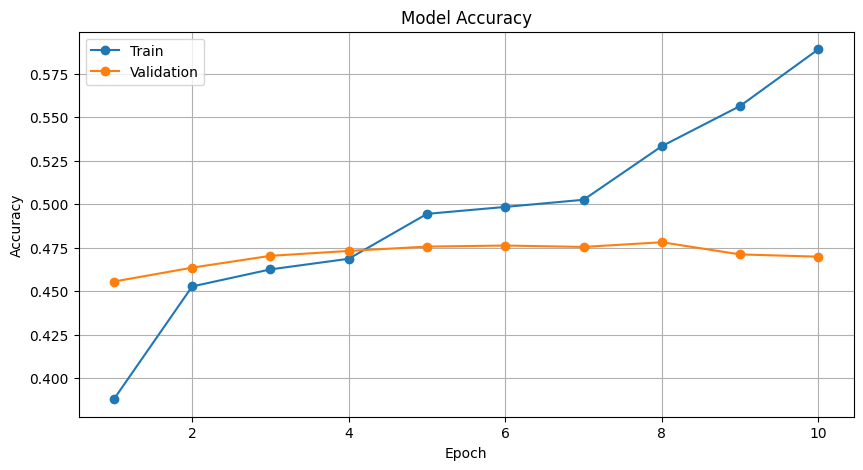

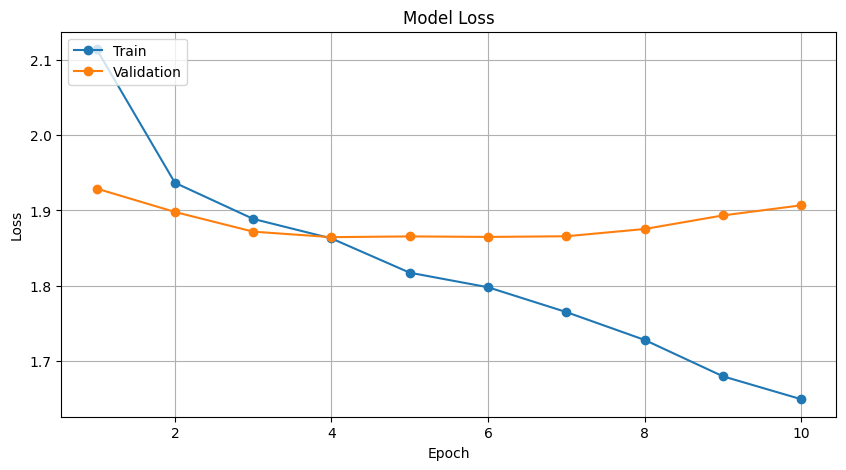

In [4]:
# Visualizing the training process
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [64]:
result =get_sentiment(model,"I am so happy today!")
plot_result(result)


1/1 - 0s - 171ms/step


In [65]:
result =get_sentiment(model,"The pain my heart feels is just too much for it to bear. Nothing eases this pain. I can’t hold myself back. I really miss you")
plot_result(result)

1/1 - 0s - 161ms/step


In [66]:
result =get_sentiment(model,"I hate this game so much,It make me angry all the time ")
plot_result(result)

1/1 - 0s - 149ms/step
